# LR/RF Hyperparameter Tuning

For LR, we want to tune regularisation $C$, which we can do efficiently using `LogisticRegressionCV`. This only supports $L_2$, so if that turns out poorly, we'll just use L1 with a high regularisation.

For RF, we want to tune
- like three things

In [40]:
import h5py, numpy, sklearn.linear_model, sklearn.model_selection, crowdastro.crowd.util, sklearn.metrics
import matplotlib.pyplot as plt, sklearn.ensemble, time
%matplotlib inline

In [41]:
with h5py.File('/Users/alger/data/Crowdastro/crowdastro-swire.h5', 'r') as f:
    swire_coords = f['/swire/cdfs/numeric'][:, :2]
data = h5py.File('/Users/alger/data/Crowdastro/all_training_data_01_05_17.h5', 'r')
list(data)

['features', 'names', 'norris_labels', 'rgz_labels', 'sets']

## Tuning LR

RGZ


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:717: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min finished


	 [ 100000.]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   53.6s finished


	 [ 100000.]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   57.9s finished


	 [ 100000.]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   56.4s finished


	 [ 7742.63682681]


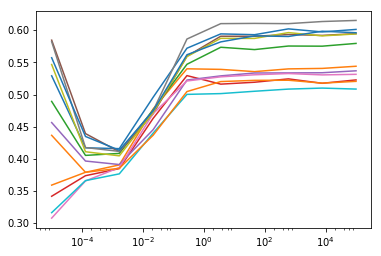

RGZ & Norris


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.8s finished


	 [ 0.00012915]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.7s finished


	 [ 0.00012915]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.1s finished


	 [ 0.00012915]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.8s finished


	 [ 0.00012915]


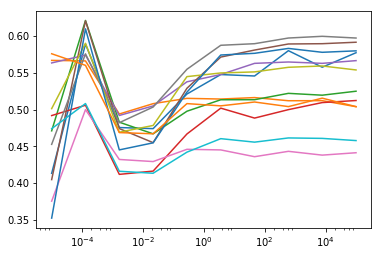

RGZ & Norris & compact


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.2s finished


	 [ 3.59381366]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.6s finished


	 [ 0.27825594]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.5s finished


	 [ 3.59381366]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.9s finished


	 [ 3.59381366]


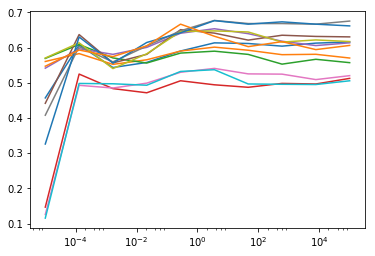

RGZ & Norris & resolved


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s finished


	 [ 0.0016681]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.6s finished


	 [ 0.0016681]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s finished


	 [ 0.00012915]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s finished


	 [ 0.00012915]


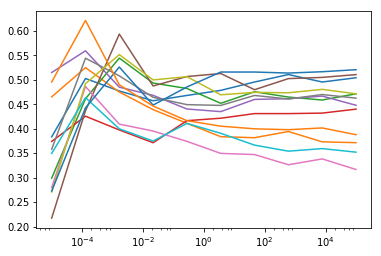

RGZ & compact


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   51.1s finished


	 [ 3.59381366]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   47.5s finished


	 [ 3.59381366]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   44.1s finished


	 [ 3.59381366]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   44.2s finished


	 [ 3.59381366]


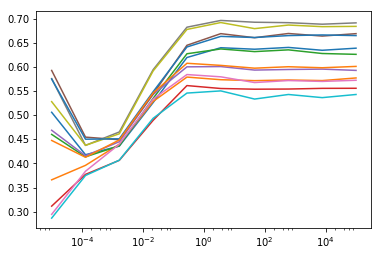

RGZ & resolved


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.1s finished


	 [ 0.00012915]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.2s finished


	 [ 0.00012915]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.5s finished


	 [ 0.00012915]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.3s finished


	 [ 0.00012915]


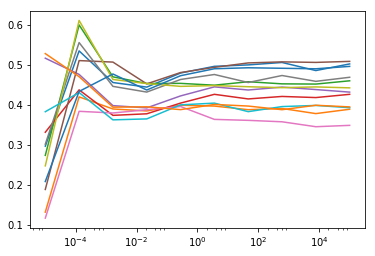

In [24]:
def balanced_score(lr, X_test, y_test):
    return crowdastro.crowd.util.balanced_accuracy(y_test, lr.predict(X_test))

# Making some splits for scikit-learn's model selection API.
# It only supports validation/training, not validation/training/testing, so we need to strip out testing.
# We need to make sure we don't peek at different label sets later on, so we should use a different C for
# each set (unless they all turn out the same). If they're all pretty close, we'll just use the C from RGZ.
for subset in data['sets']:
    print(subset)
    scores = []
    cs = []
    for train_set in data['sets'][subset]['train']:
        # Split the train set in three at (52.8, -28.1).
        middle = (52.8, -28.1)
        q1 = (swire_coords[train_set][:, 0] > middle[0]) & (swire_coords[train_set][:, 1] > middle[1])
        q2 = (swire_coords[train_set][:, 0] < middle[0]) & (swire_coords[train_set][:, 1] > middle[1])
        q3 = (swire_coords[train_set][:, 0] < middle[0]) & (swire_coords[train_set][:, 1] < middle[1])
        q4 = (swire_coords[train_set][:, 0] > middle[0]) & (swire_coords[train_set][:, 1] < middle[1])
        
        if q1.sum() < 200:
            qs = [q2, q3, q4]
        elif q2.sum() < 200:
            qs = [q1, q3, q4]
        elif q3.sum() < 200:
            qs = [q1, q2, q4]
        elif q4.sum() < 200:
            qs = [q1, q2, q3]
        else:
            raise ValueError('Invalid training data (too many samples per quadrant)')

        split = numpy.zeros((train_set.sum(),))
        split[qs[0]] = 0
        split[qs[1]] = 1
        split[qs[2]] = 2
        split = sklearn.model_selection.PredefinedSplit(split)
        lrcv = sklearn.linear_model.LogisticRegressionCV(Cs=numpy.logspace(-5, 5, 10),
                                                         cv=split, penalty='l2', solver='lbfgs',
                                                         class_weight='balanced',
                                                         scoring=lambda lr, x, y: sklearn.metrics.f1_score(
                                                             y, lr.predict(x)),
                                                         verbose=1)
        lrcv.fit(data['features'][train_set, :], data['rgz_labels'][train_set])
        print('\t', lrcv.C_)
        cs = lrcv.Cs_
        scores.append(lrcv.scores_[True].T)
    scores = numpy.concatenate(scores, axis=1)
    plt.plot(cs, scores)
    plt.xscale('log')
    plt.show()

In [ ]:
# L1
for subset in data['sets']:
    print(subset)
    scores = []
    cs = []
    for train_set in data['sets'][subset]['train']:
        # Split the train set in three at (52.8, -28.1).
        middle = (52.8, -28.1)
        q1 = (swire_coords[train_set][:, 0] > middle[0]) & (swire_coords[train_set][:, 1] > middle[1])
        q2 = (swire_coords[train_set][:, 0] < middle[0]) & (swire_coords[train_set][:, 1] > middle[1])
        q3 = (swire_coords[train_set][:, 0] < middle[0]) & (swire_coords[train_set][:, 1] < middle[1])
        q4 = (swire_coords[train_set][:, 0] > middle[0]) & (swire_coords[train_set][:, 1] < middle[1])
        
        if q1.sum() < 200:
            qs = [q2, q3, q4]
        elif q2.sum() < 200:
            qs = [q1, q3, q4]
        elif q3.sum() < 200:
            qs = [q1, q2, q4]
        elif q4.sum() < 200:
            qs = [q1, q2, q3]
        else:
            raise ValueError('Invalid training data (too many samples per quadrant)')

        split = numpy.zeros((train_set.sum(),))
        split[qs[0]] = 0
        split[qs[1]] = 1
        split[qs[2]] = 2
        split = sklearn.model_selection.PredefinedSplit(split)
        lrcv = sklearn.linear_model.LogisticRegressionCV(Cs=numpy.logspace(-5, 5, 5),
                                                         cv=split, penalty='l1', solver='liblinear',
                                                         class_weight='balanced',
                                                         scoring=lambda lr, x, y: sklearn.metrics.f1_score(
                                                             y, lr.predict(x)),
                                                         verbose=1)
        lrcv.fit(data['features'][train_set, :], data['rgz_labels'][train_set])
        print('\t', lrcv.C_)
        cs = lrcv.Cs_
        scores.append(lrcv.scores_[True].T)
    scores = numpy.concatenate(scores, axis=1)
    plt.plot(cs, scores)
    plt.xscale('log')
    plt.show()

RGZ
[LibLinear][LibLinear][LibLinear]

## Tuning RF

In [51]:
param_grid = {"min_weight_fraction_leaf": numpy.linspace(0, 0.07, 10),
              "max_depth": numpy.linspace(1, 30, 10)}

for subset in data['sets']:
    print(subset)
    for train_set in data['sets'][subset]['train']:
        now = time.time()
        # Split the train set in three at (52.8, -28.1).
        middle = (52.8, -28.1)
        q1 = (swire_coords[train_set][:, 0] > middle[0]) & (swire_coords[train_set][:, 1] > middle[1])
        q2 = (swire_coords[train_set][:, 0] < middle[0]) & (swire_coords[train_set][:, 1] > middle[1])
        q3 = (swire_coords[train_set][:, 0] < middle[0]) & (swire_coords[train_set][:, 1] < middle[1])
        q4 = (swire_coords[train_set][:, 0] > middle[0]) & (swire_coords[train_set][:, 1] < middle[1])
        
        if q1.sum() < 200:
            qs = [q2, q3, q4]
        elif q2.sum() < 200:
            qs = [q1, q3, q4]
        elif q3.sum() < 200:
            qs = [q1, q2, q4]
        elif q4.sum() < 200:
            qs = [q1, q2, q3]
        else:
            raise ValueError('Invalid training data (too many samples per quadrant)')

        split = numpy.zeros((train_set.sum(),))
        split[qs[0]] = 0
        split[qs[1]] = 1
        split[qs[2]] = 2
        split = sklearn.model_selection.PredefinedSplit(split)
        rf = sklearn.ensemble.RandomForestClassifier(class_weight='balanced', criterion='entropy')
        
        gs = sklearn.model_selection.GridSearchCV(rf, param_grid,
            scoring=lambda lr, x, y: crowdastro.crowd.util.balanced_accuracy(y, lr.predict(x)),
            cv=split)

        gs.fit(data['features'][train_set, :], data['rgz_labels'][train_set])
#         print('\t', gs.grid_scores_)
        print('', gs.best_params_)
        print('', gs.best_score_)
        print('\tTook', time.time() - now)

RGZ
 {'max_depth': 7.4444444444444446, 'min_weight_fraction_leaf': 0.0}
 0.929845929639
	Took 964.6908819675446
 {'max_depth': 7.4444444444444446, 'min_weight_fraction_leaf': 0.0}
 0.9230359061
	Took 3088.115518093109
 {'max_depth': 7.4444444444444446, 'min_weight_fraction_leaf': 0.0077777777777777784}
 0.926406428576
	Took 959.8773319721222


KeyboardInterrupt: 